In [1]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 7822-CCB4

 Directory of c:\Deepak\HOLAPS\monthly

10/06/2025  03:55 PM    <DIR>          .
10/05/2025  11:31 PM    <DIR>          ..
10/06/2025  03:55 PM               374 holaps_station_wise.ipynb
10/05/2025  10:58 PM        40,512,022 HOLAPS-GHF-Europe-2001_monthly.nc
10/05/2025  10:02 PM        40,512,022 HOLAPS-GHF-Europe-2002_monthly.nc
10/05/2025  10:10 PM        40,512,022 HOLAPS-GHF-Europe-2003_monthly.nc
10/05/2025  10:53 PM        40,512,022 HOLAPS-GHF-Europe-2004_monthly.nc
10/05/2025  11:16 PM        40,512,022 HOLAPS-GHF-Europe-2005_monthly.nc
10/05/2025  11:09 PM        40,512,022 HOLAPS-GHF-Europe-2006_monthly.nc
10/05/2025  10:12 PM        40,512,022 HOLAPS-GHF-Europe-2007_monthly.nc
10/05/2025  10:46 PM        40,512,022 HOLAPS-GHF-Europe-2008_monthly.nc
10/05/2025  09:55 PM        40,512,022 HOLAPS-GHF-Europe-2009_monthly.nc
10/05/2025  10:15 PM        40,512,022 HOLAPS-GHF-Europe-2010_monthly.nc
10/05/2025  09:5

In [ ]:
import xarray as xr
import pandas as pd
import glob
import os
import numpy as np
import re

def create_station_csvs_fixed():
   
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    stations_csv = "plot_sites_coordinates.csv"
    output_folder = "station_data"
    
    os.makedirs(output_folder, exist_ok=True)
    stations_df = pd.read_csv(stations_csv)
    
    # Process one station at a time for debugging
    for _, station in stations_df.iterrows():
        station_id = station['SITE_ID']
        station_lat = station['LATITUDE']
        station_lon = station['LONGITUDE']
        
        print(f"Processing station: {station_id}")
        all_station_data = []
        
        # Get all NetCDF files
        all_nc_files = glob.glob(os.path.join(netcdf_folder, "*.nc"))
        print(f"  Found {len(all_nc_files)} NetCDF files")
        
        for file_path in all_nc_files:
            try:
                filename = os.path.basename(file_path)
                print(f"  Reading {filename}")
                
                # Better year extraction using regex
                year_match = re.search(r'(\d{4})', filename)
                if not year_match:
                    print(f"    Could not extract year from {filename}, skipping")
                    continue
                
                year = int(year_match.group(1))
                
                # Extract variable name from filename
                var_match = re.search(r'HOLAPS-([A-Za-z0-9]+)-Europe', filename)
                if not var_match:
                    print(f"    Could not extract variable from {filename}, skipping")
                    continue
                
                var = var_match.group(1)
                
                # Open dataset with timeout protection
                ds = xr.open_dataset(file_path)
                
                # Use xarray's built-in nearest neighbor selection
                try:
                    closest_data = ds.sel(
                        latitude=station_lat,
                        longitude=station_lon,
                        method='nearest'
                    )
                except Exception as e:
                    print(f"    Nearest selection failed: {e}")
                    ds.close()
                    continue
                
                # Get the actual data variable name (exclude time_bnds)
                data_vars = [v for v in ds.data_vars.keys() if v != 'time_bnds']
                if not data_vars:
                    print(f"    No data variables found in {filename}")
                    ds.close()
                    continue
                
                data_var = data_vars[0]
                
                # Extract data for all time steps
                try:
                    data_values = closest_data[data_var].values
                    
                    # Handle scalar vs array data
                    if np.isscalar(data_values):
                        data_values = [data_values]
                    
                    time_size = len(data_values)
                    print(f"    Extracted {time_size} time steps for {var} {year}")
                    
                    for time_idx, value in enumerate(data_values):
                        if not pd.isna(value):
                            # Handle the 13-month issue: skip first if 13 months
                            if time_size == 13 and time_idx == 0:
                                continue  # Skip first month
                            
                            actual_month = time_idx + 1 if time_size != 13 else time_idx
                            
                            all_station_data.append({
                                'station_id': station_id,
                                'year': year,
                                'month': actual_month,
                                'variable': var,
                                'value': float(value),
                                'latitude': station_lat,
                                'longitude': station_lon
                            })
                            
                except Exception as e:
                    print(f"    Error extracting data: {e}")
                
                ds.close()
                
            except Exception as e:
                print(f"Error with {file_path}: {e}")
                continue
        
        # Save station data
        if all_station_data:
            df = pd.DataFrame(all_station_data)
            
            # Convert to wide format
            try:
                df_wide = df.pivot_table(
                    index=['station_id', 'year', 'month', 'latitude', 'longitude'],
                    columns='variable', 
                    values='value'
                ).reset_index()
                
                output_file = os.path.join(output_folder, f"{station_id}_all_variables.csv")
                df_wide.to_csv(output_file, index=False)
                print(f"✓ Saved: {output_file} with {len(df_wide)} records")
                
                # Show summary
                print(f"  Years: {df_wide['year'].min()}-{df_wide['year'].max()}")
                print(f"  Variables: {[col for col in df_wide.columns if col not in ['station_id', 'year', 'month', 'latitude', 'longitude']]}")
                
            except Exception as e:
                print(f"Error creating wide format: {e}")
        else:
            print(f"✗ No data found for station {station_id}")
        
        print()  # Empty line for readability

# Run the fixed version
create_station_csvs_fixed()

Processing station: BE-Bra
  Found 180 NetCDF files
  Reading HOLAPS-GHF-Europe-2001_monthly.nc
    Extracted 13 time steps for GHF 2001
  Reading HOLAPS-GHF-Europe-2002_monthly.nc
    Extracted 13 time steps for GHF 2002
  Reading HOLAPS-GHF-Europe-2003_monthly.nc
    Extracted 13 time steps for GHF 2003
  Reading HOLAPS-GHF-Europe-2004_monthly.nc
    Extracted 13 time steps for GHF 2004
  Reading HOLAPS-GHF-Europe-2005_monthly.nc
    Extracted 13 time steps for GHF 2005
  Reading HOLAPS-GHF-Europe-2006_monthly.nc
    Extracted 13 time steps for GHF 2006
  Reading HOLAPS-GHF-Europe-2007_monthly.nc
    Extracted 13 time steps for GHF 2007
  Reading HOLAPS-GHF-Europe-2008_monthly.nc
    Extracted 13 time steps for GHF 2008
  Reading HOLAPS-GHF-Europe-2009_monthly.nc
    Extracted 13 time steps for GHF 2009
  Reading HOLAPS-GHF-Europe-2010_monthly.nc
    Extracted 13 time steps for GHF 2010
  Reading HOLAPS-GHF-Europe-2011_monthly.nc
    Extracted 13 time steps for GHF 2011
  Reading HOL

In [3]:
import xarray as xr
import pandas as pd
import glob
import os
import numpy as np
import re

def create_station_csvs_final():
    """Final working version"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    stations_csv = "plot_sites_coordinates.csv"
    output_folder = "station_data"
    
    os.makedirs(output_folder, exist_ok=True)
    stations_df = pd.read_csv(stations_csv)
    
    for _, station in stations_df.iterrows():
        station_id = station['SITE_ID']
        station_lat = station['LATITUDE']
        station_lon = station['LONGITUDE']
        
        print(f"Processing station: {station_id}")
        all_station_data = []
        
        # Get all NetCDF files
        all_nc_files = glob.glob(os.path.join(netcdf_folder, "*.nc"))
        print(f"  Found {len(all_nc_files)} NetCDF files")
        
        for file_path in all_nc_files:
            try:
                filename = os.path.basename(file_path)
                
                # Extract year and variable
                year_match = re.search(r'(\d{4})', filename)
                var_match = re.search(r'HOLAPS-([A-Za-z0-9]+)-Europe', filename)
                
                if not year_match or not var_match:
                    continue
                
                year = int(year_match.group(1))
                var = var_match.group(1)
                
                print(f"  Reading {filename}")
                ds = xr.open_dataset(file_path)
                
                # Use nearest neighbor selection
                closest_data = ds.sel(
                    latitude=station_lat,
                    longitude=station_lon,
                    method='nearest'
                )
                
                # Get data variable (exclude bounds variables)
                data_vars = [v for v in ds.data_vars.keys() if 'bnds' not in v]
                if not data_vars:
                    ds.close()
                    continue
                
                data_var = data_vars[0]
                
                # Extract data - handle different data shapes
                data_values = closest_data[data_var]
                
                # Convert to numpy array and ensure it's 1D
                if data_values.ndim == 0:  # Scalar
                    data_values = np.array([data_values.values])
                else:  # Array
                    data_values = data_values.values
                
                # Flatten if needed to get 1D time series
                if data_values.ndim > 1:
                    data_values = data_values.flatten()
                
                time_size = len(data_values)
                print(f"    Extracted {time_size} time steps for {var} {year}")
                
                for time_idx, value in enumerate(data_values):
                    if not pd.isna(value):
                        # Handle the 13-month issue: skip first if 13 months
                        if time_size == 13 and time_idx == 0:
                            continue  # Skip first month
                        
                        actual_month = time_idx + 1 if time_size != 13 else time_idx
                        
                        all_station_data.append({
                            'station_id': station_id,
                            'year': year,
                            'month': actual_month,
                            'variable': var,
                            'value': float(value),
                            'latitude': station_lat,
                            'longitude': station_lon
                        })
                
                ds.close()
                
            except Exception as e:
                print(f"Error with {file_path}: {e}")
                continue
        
        # Save station data
        if all_station_data:
            df = pd.DataFrame(all_station_data)
            
            try:
                df_wide = df.pivot_table(
                    index=['station_id', 'year', 'month', 'latitude', 'longitude'],
                    columns='variable', 
                    values='value'
                ).reset_index()
                
                output_file = os.path.join(output_folder, f"{station_id}_all_variables.csv")
                df_wide.to_csv(output_file, index=False)
                print(f"✓ Saved: {output_file} with {len(df_wide)} records")
                
                # Show summary
                years = df_wide['year'].unique()
                print(f"  Years: {len(years)} ({min(years)}-{max(years)})")
                variables = [col for col in df_wide.columns if col not in ['station_id', 'year', 'month', 'latitude', 'longitude']]
                print(f"  Variables: {variables}")
                
            except Exception as e:
                print(f"Error creating wide format: {e}")
        else:
            print(f"✗ No data found for station {station_id}")
        
        print()

# Run the final version
create_station_csvs_final()

Processing station: BE-Bra
  Found 180 NetCDF files
  Reading HOLAPS-GHF-Europe-2001_monthly.nc
    Extracted 13 time steps for GHF 2001
  Reading HOLAPS-GHF-Europe-2002_monthly.nc
    Extracted 13 time steps for GHF 2002
  Reading HOLAPS-GHF-Europe-2003_monthly.nc
    Extracted 13 time steps for GHF 2003
  Reading HOLAPS-GHF-Europe-2004_monthly.nc
    Extracted 13 time steps for GHF 2004
  Reading HOLAPS-GHF-Europe-2005_monthly.nc
    Extracted 13 time steps for GHF 2005
  Reading HOLAPS-GHF-Europe-2006_monthly.nc
    Extracted 13 time steps for GHF 2006
  Reading HOLAPS-GHF-Europe-2007_monthly.nc
    Extracted 13 time steps for GHF 2007
  Reading HOLAPS-GHF-Europe-2008_monthly.nc
    Extracted 13 time steps for GHF 2008
  Reading HOLAPS-GHF-Europe-2009_monthly.nc
    Extracted 13 time steps for GHF 2009
  Reading HOLAPS-GHF-Europe-2010_monthly.nc
    Extracted 13 time steps for GHF 2010
  Reading HOLAPS-GHF-Europe-2011_monthly.nc
    Extracted 13 time steps for GHF 2011
  Reading HOL

In [4]:
def check_depth_bounds():
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    sm1_files = glob.glob(os.path.join(netcdf_folder, "*sm1*.nc"))
    
    if sm1_files:
        ds = xr.open_dataset(sm1_files[0])
        if 'depth_bnds' in ds.data_vars:
            print("Depth bounds:", ds.depth_bnds.values)
            print("Depth bounds shape:", ds.depth_bnds.shape)
        ds.close()

check_depth_bounds()

Depth bounds: [0.   0.05]
Depth bounds shape: (2,)


In [5]:
def check_data_availability():
    """Check if data actually exists in the source NetCDF files"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    stations_csv = "plot_sites_coordinates.csv"
    
    stations_df = pd.read_csv(stations_csv)
    
    # Test one problematic station
    station_id = 'SE-Svb'
    station = stations_df[stations_df['SITE_ID'] == station_id].iloc[0]
    station_lat = station['LATITUDE']
    station_lon = station['LONGITUDE']
    
    print(f"Checking data availability for {station_id} at ({station_lat}, {station_lon})")
    
    # Check all variable files
    variables = ['H', 'LE', 'GHF', 'rain', 'Rn', 'Ta', 'Td', 'Ts', 'sm1']
    
    for var in variables:
        var_files = glob.glob(os.path.join(netcdf_folder, f"*{var}*.nc"))
        
        if var_files:
            # Check first file of this variable
            test_file = var_files[0]
            print(f"\n{var} - {os.path.basename(test_file)}")
            
            try:
                ds = xr.open_dataset(test_file)
                
                # Find nearest point
                closest = ds.sel(
                    latitude=station_lat,
                    longitude=station_lon,
                    method='nearest'
                )
                
                # Get data
                data_vars = [v for v in ds.data_vars.keys() if 'bnds' not in v]
                if data_vars:
                    data_var = data_vars[0]
                    data = closest[data_var]
                    
                    # Check data characteristics
                    total_values = len(data.values) if hasattr(data.values, '__len__') else 1
                    valid_values = np.sum(~np.isnan(data.values)) if hasattr(data.values, '__len__') else (0 if np.isnan(data.values) else 1)
                    
                    print(f"  Total values: {total_values}")
                    print(f"  Valid (non-NaN) values: {valid_values}")
                    print(f"  Data: {data.values}")
                
                ds.close()
                
            except Exception as e:
                print(f"  Error: {e}")

# Run data availability check
check_data_availability()

Checking data availability for SE-Svb at (64.25611, 19.7745)

H - HOLAPS-GHF-Europe-2001_monthly.nc
  Total values: 13
  Valid (non-NaN) values: 0
  Data: [nan nan nan nan nan nan nan nan nan nan nan nan nan]

LE - HOLAPS-LE-Europe-2001_monthly.nc
  Total values: 13
  Valid (non-NaN) values: 0
  Data: [nan nan nan nan nan nan nan nan nan nan nan nan nan]

GHF - HOLAPS-GHF-Europe-2001_monthly.nc
  Total values: 13
  Valid (non-NaN) values: 0
  Data: [nan nan nan nan nan nan nan nan nan nan nan nan nan]

rain - HOLAPS-rain-Europe-2001_monthly.nc
  Total values: 13
  Valid (non-NaN) values: 0
  Data: [nan nan nan nan nan nan nan nan nan nan nan nan nan]

Rn - HOLAPS-Rn-Europe-2001_monthly.nc
  Total values: 13
  Valid (non-NaN) values: 0
  Data: [nan nan nan nan nan nan nan nan nan nan nan nan nan]

Ta - HOLAPS-Ta-Europe-2001_monthly.nc
  Total values: 13
  Valid (non-NaN) values: 0
  Data: [nan nan nan nan nan nan nan nan nan nan nan nan nan]

Td - HOLAPS-Td-Europe-2001_monthly.nc
  Tota

In [6]:
import xarray as xr
import pandas as pd
import glob
import os
import numpy as np

def calculate_dataset_extents():
    """Calculate the spatial extent of all NetCDF datasets"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    
    # Get all NetCDF files grouped by variable
    variables = ['GHF', 'rain', 'Rn', 'Ta', 'Td', 'Ts', 'H', 'LE', 'sm1']
    
    print("=== DATASET SPATIAL EXTENTS ===\n")
    
    extents = {}
    
    for var in variables:
        var_files = glob.glob(os.path.join(netcdf_folder, f"*{var}*.nc"))
        
        if var_files:
            # Use first file of each variable to check extent
            test_file = var_files[0]
            
            try:
                ds = xr.open_dataset(test_file)
                
                lat_min = float(ds.latitude.min().values)
                lat_max = float(ds.latitude.max().values)
                lon_min = float(ds.longitude.min().values)
                lon_max = float(ds.longitude.max().values)
                
                extents[var] = {
                    'lat_min': lat_min,
                    'lat_max': lat_max, 
                    'lon_min': lon_min,
                    'lon_max': lon_max,
                    'file': os.path.basename(test_file)
                }
                
                print(f"{var:6} | Lat: {lat_min:6.2f} to {lat_max:6.2f} | Lon: {lon_min:6.2f} to {lon_max:6.2f}")
                
                ds.close()
                
            except Exception as e:
                print(f"{var:6} | Error: {e}")
        else:
            print(f"{var:6} | No files found")
    
    return extents

def check_stations_in_extents(extents):
    """Check if stations fall within dataset extents"""
    
    stations_csv = "plot_sites_coordinates.csv"
    stations_df = pd.read_csv(stations_csv)
    
    print(f"\n=== STATION LOCATION CHECK ===\n")
    
    # Calculate overall data extent (union of all variables)
    all_lat_min = min([extents[var]['lat_min'] for var in extents])
    all_lat_max = max([extents[var]['lat_max'] for var in extents])
    all_lon_min = min([extents[var]['lon_min'] for var in extents])
    all_lon_max = max([extents[var]['lon_max'] for var in extents])
    
    print(f"Overall data extent:")
    print(f"Latitude:  {all_lat_min:.2f} to {all_lat_max:.2f}")
    print(f"Longitude: {all_lon_min:.2f} to {all_lon_max:.2f}")
    
    print(f"\nStation location analysis:")
    
    for _, station in stations_df.iterrows():
        station_id = station['SITE_ID']
        station_lat = station['LATITUDE']
        station_lon = station['LONGITUDE']
        
        lat_in_bounds = all_lat_min <= station_lat <= all_lat_max
        lon_in_bounds = all_lon_min <= station_lon <= all_lon_max
        in_bounds = lat_in_bounds and lon_in_bounds
        
        status = "✓ INSIDE" if in_bounds else "✗ OUTSIDE"
        
        print(f"{station_id:10} | {station_lat:8.4f}, {station_lon:8.4f} | {status}")
        
        if not in_bounds:
            if station_lat < all_lat_min:
                print(f"           | → Too far SOUTH (needs lat > {all_lat_min:.2f})")
            elif station_lat > all_lat_max:
                print(f"           | → Too far NORTH (needs lat < {all_lat_max:.2f})")
            if station_lon < all_lon_min:
                print(f"           | → Too far WEST (needs lon > {all_lon_min:.2f})")
            elif station_lon > all_lon_max:
                print(f"           | → Too far EAST (needs lon < {all_lon_max:.2f})")

def analyze_problematic_stations():
    """Detailed analysis of problematic stations"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    stations_csv = "plot_sites_coordinates.csv"
    
    stations_df = pd.read_csv(stations_csv)
    problematic = ['SE-Svb', 'SE-Nor', 'FI-Hyy', 'FI-Let']
    
    print(f"\n=== PROBLEMATIC STATIONS DETAILED ANALYSIS ===\n")
    
    # Use SM1 file as reference
    test_file = glob.glob(os.path.join(netcdf_folder, "*sm1*.nc"))[0]
    ds = xr.open_dataset(test_file)
    
    lat_min = float(ds.latitude.min().values)
    lat_max = float(ds.latitude.max().values)
    lon_min = float(ds.longitude.min().values)
    lon_max = float(ds.longitude.max().values)
    
    print(f"Reference dataset bounds:")
    print(f"Latitude:  {lat_min:.2f} to {lat_max:.2f}")
    print(f"Longitude: {lon_min:.2f} to {lon_max:.2f}")
    
    print(f"\nProblematic stations:")
    for station_id in problematic:
        station = stations_df[stations_df['SITE_ID'] == station_id].iloc[0]
        station_lat = station['LATITUDE']
        station_lon = station['LONGITUDE']
        
        lat_dist = 0
        lon_dist = 0
        
        if station_lat < lat_min:
            lat_dist = lat_min - station_lat
        elif station_lat > lat_max:
            lat_dist = station_lat - lat_max
            
        if station_lon < lon_min:
            lon_dist = lon_min - station_lon
        elif station_lon > lon_max:
            lon_dist = station_lon - lon_max
            
        total_dist = np.sqrt(lat_dist**2 + lon_dist**2)
        
        print(f"\n{station_id}:")
        print(f"  Location: {station_lat:.4f}, {station_lon:.4f}")
        print(f"  Distance outside bounds: {total_dist:.4f} degrees")
        if lat_dist > 0:
            print(f"  → {lat_dist:.4f} degrees outside latitude bounds")
        if lon_dist > 0:
            print(f"  → {lon_dist:.4f} degrees outside longitude bounds")
    
    ds.close()

# Run all analyses
extents = calculate_dataset_extents()
check_stations_in_extents(extents)
analyze_problematic_stations()

=== DATASET SPATIAL EXTENTS ===

GHF    | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
rain   | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
Rn     | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
Ta     | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
Td     | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
Ts     | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
H      | Lat:  30.00 to  60.05 | Lon: -15.00 to  49.99
LE     | Lat:  30.00 to  60.00 | Lon: -15.00 to  46.97
sm1    | Lat:  30.00 to  60.00 | Lon: -15.00 to  46.97

=== STATION LOCATION CHECK ===

Overall data extent:
Latitude:  30.00 to 60.05
Longitude: -15.00 to 49.99

Station location analysis:
BE-Bra     |  51.3076,   4.5198 | ✓ INSIDE
BE-Vie     |  50.3050,   5.9981 | ✓ INSIDE
CH-Dav     |  46.8153,   9.8559 | ✓ INSIDE
CZ-BK1     |  49.5021,  18.5369 | ✓ INSIDE
CZ-wet     |  49.0247,  14.7704 | ✓ INSIDE
DE-Geb     |  51.0997,  10.9146 | ✓ INSIDE
DE-Gri     |  50.9500,  13.5126 | ✓ INSIDE
DE-HoH     |  52.0866,  11.2224 | ✓ 

In [7]:
import xarray as xr
import pandas as pd
import glob
import os
import numpy as np

def debug_se_nor_coverage():
    """Debug why SE-Nor only gets some variables"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    station_lat = 60.08649722
    station_lon = 17.47950278
    
    print(f"=== DEBUG SE-NOR at ({station_lat}, {station_lon}) ===\n")
    
    variables = ['H', 'LE', 'sm1', 'GHF', 'rain', 'Rn', 'Ta', 'Td', 'Ts']
    
    for var in variables:
        var_files = glob.glob(os.path.join(netcdf_folder, f"*{var}*.nc"))
        
        if var_files:
            test_file = var_files[0]
            print(f"{var}: {os.path.basename(test_file)}")
            
            try:
                ds = xr.open_dataset(test_file)
                
                # Check actual data bounds (not just coordinate bounds)
                data_vars = [v for v in ds.data_vars.keys() if 'bnds' not in v]
                if data_vars:
                    data_var = data_vars[0]
                    
                    # Find nearest point
                    closest = ds.sel(
                        latitude=station_lat,
                        longitude=station_lon, 
                        method='nearest'
                    )
                    
                    selected_lat = closest.latitude.values
                    selected_lon = closest.longitude.values
                    
                    # Check if data exists at this point
                    data = closest[data_var].values
                    valid_count = np.sum(~np.isnan(data))
                    
                    print(f"  Selected: ({selected_lat:.4f}, {selected_lon:.4f})")
                    print(f"  Valid data: {valid_count}/13 months")
                    print(f"  Data available: {'✓' if valid_count > 0 else '✗'}")
                    
                ds.close()
                
            except Exception as e:
                print(f"  Error: {e}")
        else:
            print(f"{var}: No files found")
        
        print()

# Run the debug
debug_se_nor_coverage()

=== DEBUG SE-NOR at (60.08649722, 17.47950278) ===

H: HOLAPS-GHF-Europe-2001_monthly.nc
  Selected: (60.0500, 17.4938)
  Valid data: 0/13 months
  Data available: ✗

LE: HOLAPS-LE-Europe-2001_monthly.nc
  Selected: (60.0000, 17.4938)
  Valid data: 13/13 months
  Data available: ✓

sm1: HOLAPS-sm1-Europe-2001_monthly.nc
  Selected: (60.0000, 17.4938)
  Valid data: 13/13 months
  Data available: ✓

GHF: HOLAPS-GHF-Europe-2001_monthly.nc
  Selected: (60.0500, 17.4938)
  Valid data: 0/13 months
  Data available: ✗

rain: HOLAPS-rain-Europe-2001_monthly.nc
  Selected: (60.0500, 17.4938)
  Valid data: 0/13 months
  Data available: ✗

Rn: HOLAPS-Rn-Europe-2001_monthly.nc
  Selected: (60.0500, 17.4938)
  Valid data: 0/13 months
  Data available: ✗

Ta: HOLAPS-Ta-Europe-2001_monthly.nc
  Selected: (60.0500, 17.4938)
  Valid data: 0/13 months
  Data available: ✗

Td: HOLAPS-Td-Europe-2001_monthly.nc
  Selected: (60.0500, 17.4938)
  Valid data: 0/13 months
  Data available: ✗

Ts: HOLAPS-Ts-Euro

In [9]:
def check_all_h_files():
    """Check all H files for data at SE-Nor"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    station_lat = 60.08649722
    station_lon = 17.47950278
    
    h_files = glob.glob(os.path.join(netcdf_folder, "*H*.nc"))
    print(f"Found {len(h_files)} H files:")
    
    for h_file in h_files:
        print(f"\n{os.path.basename(h_file)}:")
        try:
            ds = xr.open_dataset(h_file)
            closest = ds.sel(latitude=station_lat, longitude=station_lon, method='nearest')
            data_var = [v for v in ds.data_vars.keys() if 'bnds' not in v][0]
            data = closest[data_var].values
            valid_count = np.sum(~np.isnan(data))
            print(f"  Valid data: {valid_count}/13 at ({closest.latitude.values:.4f}, {closest.longitude.values:.4f})")
            ds.close()
        except Exception as e:
            print(f"  Error: {e}")

check_all_h_files()

Found 180 H files:

HOLAPS-GHF-Europe-2001_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2002_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2003_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2004_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2005_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2006_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2007_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2008_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2009_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2010_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2011_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2012_monthly.nc:
  Valid data: 0/13 at (60.0500, 17.4938)

HOLAPS-GHF-Europe-2013_monthly.nc:
  Valid data: 0/13 at

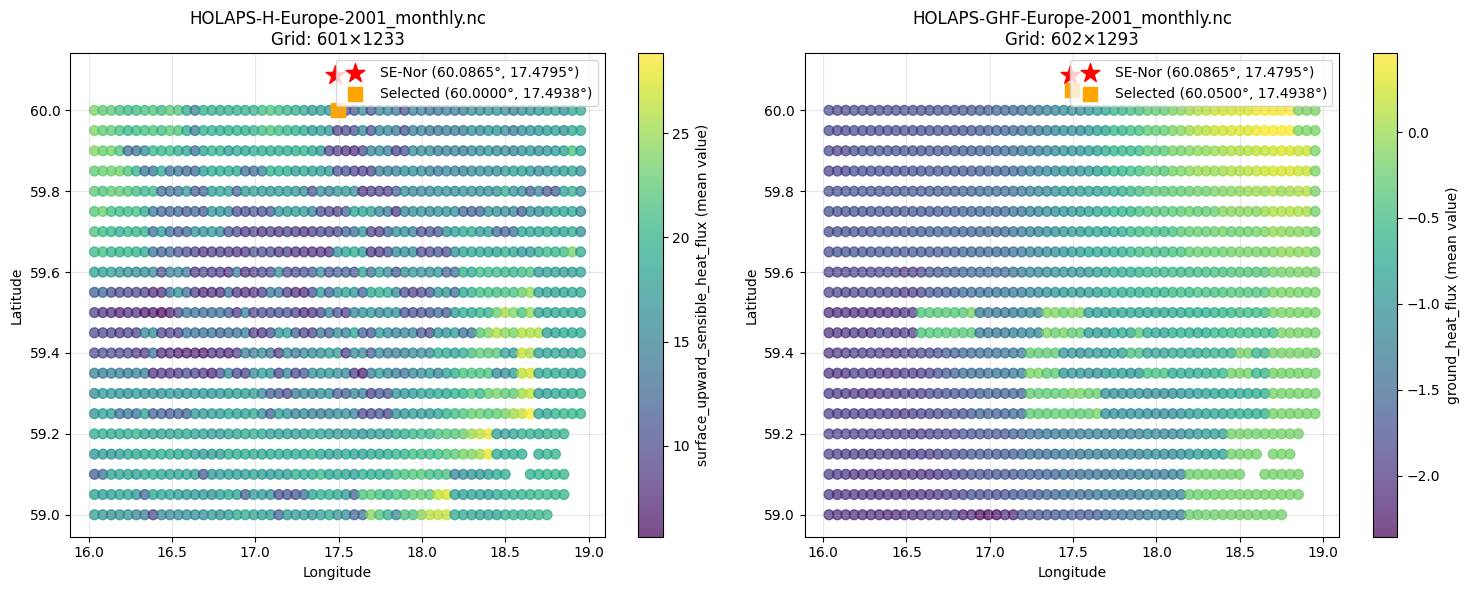

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

def visualize_grid_differences():
    """Visualize the grid differences between variable types"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    station_lat = 60.08649722
    station_lon = 17.47950278
    
    # Files to compare
    h_file = "HOLAPS-H-Europe-2001_monthly.nc"
    ghf_file = "HOLAPS-GHF-Europe-2001_monthly.nc"
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for idx, (filename, ax) in enumerate(zip([h_file, ghf_file], [ax1, ax2])):
        file_path = os.path.join(netcdf_folder, filename)
        
        ds = xr.open_dataset(file_path)
        data_vars = [v for v in ds.data_vars.keys() if 'bnds' not in v]
        data_var = data_vars[0]
        
        # Get grid coordinates
        lats = ds.latitude.values
        lons = ds.longitude.values
        
        # Find northern region (59-61°N, 16-19°E)
        lat_mask = (lats >= 59.0) & (lats <= 61.0)
        lon_mask = (lons >= 16.0) & (lons <= 19.0)
        
        # Create meshgrid for plotting
        lon_grid, lat_grid = np.meshgrid(lons[lon_mask], lats[lat_mask])
        
        # Get data for this region
        region_data = ds[data_var].isel(
            latitude=lat_mask,
            longitude=lon_mask
        ).mean(dim='time')  # Average over time
        
        # Plot
        im = ax.scatter(lon_grid, lat_grid, c=region_data.values, 
                       cmap='viridis', s=50, alpha=0.7)
        
        # Mark SE-Nor location
        ax.scatter(station_lon, station_lat, c='red', s=200, marker='*', 
                  label=f'SE-Nor ({station_lat:.4f}°, {station_lon:.4f}°)')
        
        # Mark selected grid point
        closest = ds.sel(latitude=station_lat, longitude=station_lon, method='nearest')
        selected_lat = closest.latitude.values
        selected_lon = closest.longitude.values
        ax.scatter(selected_lon, selected_lat, c='orange', s=100, marker='s',
                  label=f'Selected ({selected_lat:.4f}°, {selected_lon:.4f}°)')
        
        ax.set_title(f'{filename}\nGrid: {lats.shape[0]}×{lons.shape[0]}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label=f'{data_var} (mean value)')
        
        ds.close()
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_grid_differences()

In [14]:
def ascii_visualization():
    """Simple ASCII art to show the grid alignment"""
    
    netcdf_folder = r"C:\Deepak\HOLAPS\monthly"
    station_lat = 60.08649722
    
    files_to_compare = [
        ("H Files", "HOLAPS-H-Europe-2001_monthly.nc"),
        ("GHF Files", "HOLAPS-GHF-Europe-2001_monthly.nc")
    ]
    
    print("=== GRID ALIGNMENT VISUALIZATION ===\n")
    print(f"SE-Nor at: {station_lat:.4f}°N\n")
    
    for label, filename in files_to_compare:
        file_path = os.path.join(netcdf_folder, filename)
        
        ds = xr.open_dataset(file_path)
        lats = ds.latitude.values
        
        # Find northern points
        northern_lats = lats[lats >= 59.9]
        northern_lats = np.sort(northern_lats)
        
        print(f"{label}:")
        print("Latitude points near 60°N:")
        
        for lat in northern_lats[:10]:  # Show first 10 northern points
            distance = abs(lat - station_lat)
            marker = "  ← SELECTED" if distance == min(abs(northern_lats - station_lat)) else ""
            data_status = " (DATA)" if distance < 0.01 else " (NO DATA)"
            print(f"  {lat:.4f}° - distance: {distance:.4f}°{data_status}{marker}")
        
        print()
        ds.close()

# Run ASCII visualization
ascii_visualization()

=== GRID ALIGNMENT VISUALIZATION ===

SE-Nor at: 60.0865°N

H Files:
Latitude points near 60°N:
  59.9000° - distance: 0.1865° (NO DATA)
  59.9500° - distance: 0.1365° (NO DATA)
  60.0000° - distance: 0.0865° (NO DATA)  ← SELECTED

GHF Files:
Latitude points near 60°N:
  59.9000° - distance: 0.1865° (NO DATA)
  59.9500° - distance: 0.1365° (NO DATA)
  60.0000° - distance: 0.0865° (NO DATA)
  60.0500° - distance: 0.0365° (NO DATA)  ← SELECTED

